## **06. 규제 선형 모델 - 릿지, 라쏘, 엘라스틱넷**

**규제 선형 모델의 개요**

다항 회귀에서 Degree가 1인 경우는 지나치게 예측 곡선을 단순화해 데이터에 적합하지 않는 과소적합 모델이 만들어졌다. 반대로 Degree 15의 경우 지나치게 모든 데이터에 적합한 회귀식을 만들기 위해 다항식이 복잡해지고 회귀 계수가 매우 크게 설정되면서 평가 데이터 세트에 대해서 형편없는 예측 성능을 보였다. 따라서 회귀 모델은 적절히 데이터에 적합하면서도 회귀 계수가 기하급수적으로 커지는 것을 제어할 수 있어야 한다.

선형 모델의 비용 함수는 RSS를 최소화하는, 즉 실제 값과 예측 값의 차이를 최소화하는 것만 고려했다. 그러다보니 학습 데이터에 지나치게 맞추게 되고, 회귀 계수가 쉽게 커졌다. 이럴 경우 변동성이 오히려 심해져서 테스트 데이터 세트에서는 예측 성능이 저하되기 쉽다. 이를 반영해 비용 함수는 학습 데이터의 잔차 오류 값을 최소로 하는 RSS 최소화 방법과 과적합을 방지하기 위해 회귀 계수 값이 커지지 않도록 하는 방법이 서로 균형을 이뤄야 한다.
$$비용 함수 목표 = Min(RSS(W)+alpha*(W의 크기))$$
alpha : 학습 데이터 적합 정도와 회귀 계수 값의 크기를 제어하는 튜닝 파라미터.
* alpha가 0 또는 매우 작은 값이면 비용 함수 식은 기존과 동일한 Min(RSS(W)+0)이 된다.
* alpha가 무한대 또는 매우 큰 값이면 RSS(W)에 비해 alpha*(W의 크기) 값이 너무 매우 커지므로 W 값을 0 또는 매우 작게 만들어야 Cost가 최소화되는 비용 함수의 목표를 달성할 수 있다.

즉, alpha 값을 크게 하면 비용 함수는 회귀 계수 W의 값을 작게 해 과적합을 개선할 수 있으며, alpha 값을 작게 하면 회귀 계수 W의 값이 커져도 어느 정도 상쇄가 가능하므로 학습 데이터 적합을 더 개선할 수 있다. 즉, alpha를 0에서부터 값을 증가시키면 회귀 계수 값의 크기를 감소시킬 수 있다.

이처럼 비용 함수에 alpha 값으로 페널티를 부여해 회귀 계수 값의 크기를 감소시켜 과적합을 개선하는 방식을 규제(Regularization)라고 부른다. 규제는 크게 L2 방식과 L1 방식으로 구분된다.
* L2 규제 : alpha*(W의 크기)와 같이 W의 제곱에 대해 패널티를 부여하는 방식을 말한다. L2 규제를 적용한 회귀를 릿지(Ridge) 회귀라고 한다.
* 라쏘(Lasso) 회귀는 L1 규제를 적용한 회귀이다. L1 규제는 alpha*(W의 크기)와 같이 W의 절댓값에 대해 페널티를 부여한다. L1 규제를 적용하면 영향력이 크지 않은 회귀 계수 값을 0으로 변환한다.

**릿지 회귀**

사이킷런은 Ridge 클래스를 통해 릿지 회귀를 구현한다. Ridge 클래스의 주요 생성 파라미터는 alpha이며, 이는 릿지 회귀의 alpha L2 규제 계수에 해당한다.

**예제1**

앞 예제의 보스턴 주택 가격을 Ridge 클래스를 이용해 다시 예측하고, 예측 성능을 cross_val_score()로 평가해 보겠다. 앞의 LinearRegression 예제에서 사용한 피처 데이트 세트인 X_data와 Target 데이터 세트인 y_target을 그대로 이용한다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
%matplotlib inline

# boston 데이터 세트 로드
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
boston = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :3]])

# feature name이 없으므로 따로 지정해줘야 함.
feature_names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX' ,'PTRATIO', 'B' ,'LSTAT', 'PRICE']
bostonDF = pd.DataFrame(boston, columns=feature_names)
print('Boston 데이터 세트 크기:', bostonDF.shape)
bostonDF.head()

Boston 데이터 세트 크기: (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
y_target=bostonDF['PRICE']
X_data=bostonDF.drop(['PRICE'], axis=1, inplace=False)
X_train, X_test, y_train, y_test=train_test_split(X_data, y_target, test_size=0.3, random_state=156)

In [4]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
# alpha=10으로 설정해 릿지 회귀 수행
ridge=Ridge(alpha=10)
neg_mse_scores=cross_val_score(ridge, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
rmse_scores=np.sqrt(-1*neg_mse_scores)
avg_rmse=np.mean(rmse_scores)
print('5 folds의 개별 Negative MSE scores :', np.round(neg_mse_scores, 3))
print('5 folds의 개별 RMSE scores :', np.round(rmse_scores, 3))
print('5 folds의 평균 RMSE : {0:.3f}'.format(avg_rmse))

5 folds의 개별 Negative MSE scores : [-11.422 -24.294 -28.144 -74.599 -28.517]
5 folds의 개별 RMSE scores : [3.38  4.929 5.305 8.637 5.34 ]
5 folds의 평균 RMSE : 5.518


릿지의 5개 폴드 세트의 평균 RMSE가 5.518이다. 앞 예제의 규제가 없는 LinearRegression의 RMSE 평균인 5.829보다 더 뛰어난 예측 성능을 보여준다.

**예제2**

이번에는 릿지의 alpha 값을 0, 0.1, 1, 10, 100으로 변화시키면서 RMSE와 회귀 계수 값의 변화를 살펴보겠다. alpha 값을 변화하면서 RMSE 값과 각 피처의 회귀 계수를 시각화하고 DataFrame에 저장하는 예제이다. 예제의 결과에서 보겠지만, 릿지 회귀는 alpha 값이 커질수록 회귀 계수 값을 작게 만든다. 먼저 alpha 값의 변화에 따른 5 폴드의 RMSE 평균값을 반환하는 코드부터 작성해보자.

In [5]:
# 릿지에 사용될 alpha 파라미터의 값 정의
alphas=[0, 0.1, 1, 10, 100]

# alphas list 값을 반복하면서 alpha에 따른 평균 rmse 구하기
for alpha in alphas:
    ridge=Ridge(alpha=alpha)
    
    # cross_val_score를 이용해 5 폴드의 평균 RMSE 계산
    neg_mse_scores=cross_val_score(ridge, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
    avg_rmse=np.mean(np.sqrt(-1*neg_mse_scores))
    print('alpha가 {0}일 때 5 folds의 평균 RMSE : {1:.3f}'.format(alpha, avg_rmse))

alpha가 0일 때 5 folds의 평균 RMSE : 5.829
alpha가 0.1일 때 5 folds의 평균 RMSE : 5.788
alpha가 1일 때 5 folds의 평균 RMSE : 5.653
alpha가 10일 때 5 folds의 평균 RMSE : 5.518
alpha가 100일 때 5 folds의 평균 RMSE : 5.330


alpha가 100일 때 평균 RMSE가 5.330으로 가장 좋다. 이번에는 alpha 값의 변화에 따른 피처의 회귀 계수 값을 가로 막대 그래프로 시각화해 보자. 회귀 계수를 Ridge 객체의 coef_ 속성에 추출한 뒤 Series 객체로 만들어 시본 가로 막대 차트로 표시하고, DataFrame에 alpha 값별 회귀 계수로 저장한다.

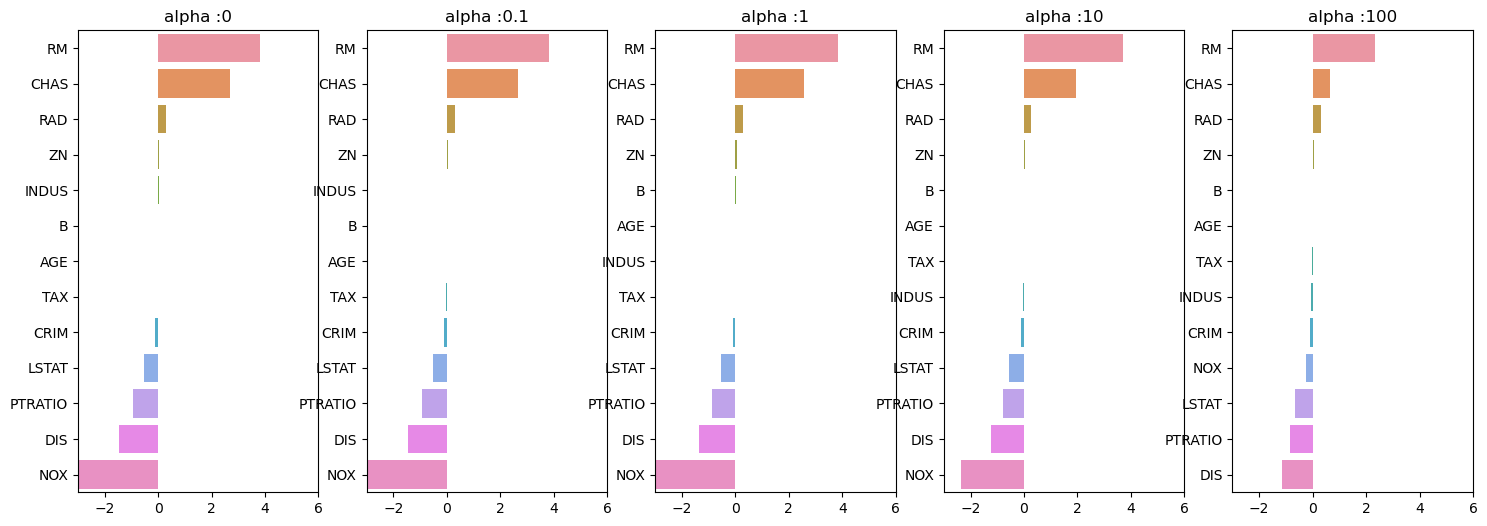

In [7]:
# 각 alpha에 따른 회귀 계수 값을 시각화하기 위해 5개의 열로 된 맷플롯립 축 생성
fig, axs=plt.subplots(figsize=(18, 6), nrows=1, ncols=5)

# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 생성
coeff_df=pd.DataFrame()

# alpha 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장. pos는 axis의 위치 지정
for pos, alpha in enumerate(alphas):
    ridge=Ridge(alpha=alpha)
    ridge.fit(X_data, y_target)
    
    # alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장. pos는 axis의 위치 지정
    for pos, alpha in enumerate(alphas):
        ridge=Ridge(alpha=alpha)
        ridge.fit(X_data, y_target)
        
        # alpha에 따른 피처별로 회귀 계수를 Series로 변환하고 이를 DataFrame의 칼럼으로 추가
        coeff=pd.Series(data=ridge.coef_, index=X_data.columns)
        colname='alpha :'+str(alpha)
        coeff_df[colname]=coeff
        
        # 막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화. 회귀 계수 값이 높은 순으로 표현
        coeff=coeff.sort_values(ascending=False)
        axs[pos].set_title(colname)
        axs[pos].set_xlim(-3, 6)
        sns.barplot(x=coeff.values, y=coeff.index, ax=axs[pos])

# for문 바깥에서 맷플롯립의 show 호출 및 alpha에 따른 피처별 회귀 계수를 DataFrame으로 표시
plt.show()

alpha 값을 증가시킬수록 회귀 계수의 값은 지속적으로 작아진다. 특히 NOX 피처의 경우 alpha 값을 계속 증가시킴에 따라 회귀 계수가 크게 작아진다. DataFrame에 저장된 alpha 값의 변화에 따른 릿지 회귀 계수 값을 구해 보자.

In [8]:
ridge_alphas=[0, 0.1, 1, 10, 100]
sort_column='alpha :'+str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

,alpha :0,alpha :0.1,alpha :1,alpha :10,alpha :100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


alpha 값이 증가하면서 회귀 계수가 지속적으로 작아지고 있음을 알 수 있다. 하지만 릿지 회귀의 경우, 회귀 계수를 0으로 만들지는 않았다.

**라쏘 회귀**

W의 절댓값에 페널티를 부과하는 L1 규제를 선형 회귀에 적용한 것이 라쏘(Lasso) 회귀이다. L2 규제가 회귀 계수의 크기를 감소시키는 데 반해, L1 규제는 불필요한 회귀 계수를 급격하게 감소시켜 0으로 만들고 제거한다. 이러한 측면에서 L1 규제는 적절한 피처만 회귀에 포함시키는 피처 선택의 특성을 가지고 있다.

사이킷런은 Lasso 클래스를 통해 라쏘 회귀를 구현한다. Lasso 클래스의 주요 생성 파라미터는 alpha이며, 이는 라쏘 회귀의 alpha L1 규제 계수에 해당한다. 이 Lasso 클래스를 이용해 바로 이전의 릿지 회귀 예제 코드와 유사하게 라쏘의 alpha 값을 변화시키면서 RMSE와 각 피처의 회귀 계수를 출력해 보겠다.

get_linear_reg_eval()은 인자로 회귀 모델의 이름, alpha 값들의 리슽, 피처 데이터 세트와 타깃 데이터 세트를 입력 받아서 alpha 값에 따른 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DataFrame으로 반환한다.

In [16]:
from sklearn.linear_model import Lasso, ElasticNet

# alpha 값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DataFrame으로 반환
def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, verbose=True):
    coeff_df=pd.DataFrame()
    if verbose: print('#######', model_name, '######')
    for param in params:
        if model_name=='Ridge': model=Ridge(alpha=param)
        elif model_name=='Lasso': model=Lasso(alpha=param)
        elif model_name=='ElasticNet' : model=ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mse_scores=cross_val_score(model, X_data_n, y_target_n, scoring='neg_mean_squared_error', cv=5)
        avg_rmse=np.mean(np.sqrt(-1*neg_mse_scores))
        print('alpha가 {0}일 때 5 폴드 세트의 평균 RMSE : {1:.3f}'.format(param, avg_rmse))
        
        # cross_val_score은 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출
        model.fit(X_data, y_target)
        
        # alpha에 따른 피처별 회귀 계수를 Series로 반환하고 이를 DataFrame의 칼럼으로 추가
        coeff=pd.Series(data=model.coef_, index=X_data.columns)
        colname='alpha :'+str(param)
        coeff_df[colname]=coeff
    return coeff_df

위 함수를 이용해 alpha 값의 변화에 따른 RMSE와 그때의 회귀 계수들을 출력해 보자. alpha 값은 [0.07, 0.1, 0.5, 1, 3]으로 입력한다. get_linear_reg_evla()에 모델명을 'Lasso'로 입력하면 라쏘 모델 기반으로 수행한다.

In [13]:
# 라쏘에 사용될 alpha 파라미터의 값을 정의하고 get_linear_reg_eval() 함수 호출
lasso_alphas=[0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df=get_linear_reg_eval('Lasso', params=lasso_alphas, X_data_n=X_data, y_target_n=y_target)

####### Lasso ######
alpha가 0.07일 때 5 폴드 세트의 평균 RMSE : 5.612
alpha가 0.1일 때 5 폴드 세트의 평균 RMSE : 5.615
alpha가 0.5일 때 5 폴드 세트의 평균 RMSE : 5.669
alpha가 1일 때 5 폴드 세트의 평균 RMSE : 5.776
alpha가 3일 때 5 폴드 세트의 평균 RMSE : 6.189


alpha가 0.07일 때 가장 좋은 평균 RMSE를 보인다. 앞의 릿지 평균 5.518보다는 약간 떨어지는 수치지만, LinearRegression 평균인 5.836보다는 향상되었다. 다음은 alpha 값에 따른 피처별 회귀 계수이다.

In [14]:
# 반환된 coeff_lasso_df를 첫 번째 칼럼순으로 내림차순 정렬해 회귀 계수 DataFrame 출력
sort_column='alpha :'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

,alpha :0.07,alpha :0.1,alpha :0.5,alpha :1,alpha :3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


alpha의 크기가 증가함에 따라 일부 피처의 계수는 아예 0으로 바뀌고 있다. NOX 속성은 alpha가 0.07일 때부터 회귀 계수가 0이며, alpha를 증가시키면서 INDUS, CHAS와 같은 속성의 회귀 계수가 0으로 바뀐다. 회귀 계수가 0인 피처는 회귀 식에서 제외되면서 피처 선택의 효과를 얻을 수 있다.

**엘라스틱넷 회귀**

엘라스틱넷(Elastic Net) 회귀는 L2 규제와 L1 규제를 결합한 회귀이다. 엘라스틱넷은 라쏘 회귀가 서로 상관관계가 높은 피처들의 경우, 이들 중에서 중요 피처만을 셀렉션하고 다른 피처들은 모두 회귀 계수를 0으로 만드는 성향이 강하다. 특히 이러한 성향으로 인해 alpha 값에 따라 회귀 계수의 값이 급격히 변동할 수도 있는데, 엘라스틱넷 회귀는 이를 완화하기 위해 L2 규제를 라쏘 회귀에 추가한 것이다. 반대로 엘라스틱넷 회귀의 단점은 L1과 L2 규제가 결합된 규제로 인해 수행 시간이 상대적으로 오래 걸린다는 것이다.

사이킷런은 ElasticNet 클래스를 통해서 엘라스틱넷 회귀를 구현한다. ElasticNet 클래스의 주요 생성 파라미터는 alpha와 l1_ratio이다. ElasticNet 클래스의 alpha는 Ridge와 Lasso 클래스의 alpha 값과는 다르다. 엘라스틱넷의 규제는 a*L1+b*L2로 정의될 수 있으며, 이때 a는 L1 규제의 alpha 값, b는 L2 규제의 alpha 값이다. 따라서 ElasticNet 클래스의 alpha 파라미터 값은 a+b이다. ElasticNet 클래스의 l1_ratio 파라미터 값은 a/(a+b)이다. l1_ratio가 0이면 a가 0이므로 L2 규제와 동일하다. l1_ratio가 1이면 b가 0이므로 L1 규제와 동일하다.

ElasticNet 클래스를 이용해 바로 이전의 릿지, 라쏘 회귀 예제 코드와 유사하게 엘라스틱넷 alpha 값을 변화시키면서 RMSE와 각 피처의 회귀 계수를 출력해보겠다. 앞에서 생성한 get_linear_reg_eval() 함수를 이용한다.

In [17]:
# 엘라스틱넷에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
# l1_ratio는 0.7로 고정
elastic_alphas=[0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df=get_linear_reg_eval('ElasticNet', params=elastic_alphas, X_data_n=X_data, y_target_n=y_target)

####### ElasticNet ######
alpha가 0.07일 때 5 폴드 세트의 평균 RMSE : 5.542
alpha가 0.1일 때 5 폴드 세트의 평균 RMSE : 5.526
alpha가 0.5일 때 5 폴드 세트의 평균 RMSE : 5.467
alpha가 1일 때 5 폴드 세트의 평균 RMSE : 5.597
alpha가 3일 때 5 폴드 세트의 평균 RMSE : 6.068


In [18]:
# 반환된 coeff_elastic_df를 첫 번째 칼럼순으로 내림차순 정렬해 회귀계수 DataFrame 출력
sort_column='alpha :'+str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_column, ascending=False)

,alpha :0.07,alpha :0.1,alpha :0.5,alpha :1,alpha :3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


alpha=0.5일 때 RMSE가 5.468로 가장 좋은 예측 성능을 보이고 있다. alpha 값에 따른 피처들의 회귀 계수 값이 라쏘보다는 상대적으로 0이 되는 값이 적다.

지금까지 규제 선형 회귀의 가장 대표적인 기법인 릿지, 라쏘, 엘라스틱넷 회귀를 살펴봤다.

선형 회귀의 경우 최적의 하이퍼 파라미터를 찾아내는 것 못지 않게 먼저 데이터 분포도의 정규화와 인코딩 방법이 매우 중요하다.

**선형 회귀 모델을 위한 데이터 변환**

선형 회귀 모델과 같은 선형 모델은 일반적으로 피처와 티깃값 간에 선형의 관계가 있다고 가정하고, 이러한 최적의 선형 함수를 찾아 결과를 예측한다. 또한 선형 회귀 모델은 피처값과 타깃값의 분포가 정규분포(즉 평균을 중심으로 종 모양으로 데이터 값이 분포된 형태) 형태를 매우 선호한다. 특히 타깃 값의 경우 정규 분포 형태가 아니라 특정 값의 분포가 치우친 왜곡(Skew)된 형태의 분포도일 경우 예측 성능에 부정적인 영향을 미칠 가능성이 높다. 피처값 역시 결정값보다는 덜하지만 왜곡된 분포도로 인해 예측 성능에 부정적인 영향을 미칠 수 있다. 따라서 선형 회귀 모델을 적용하기 전에 먼저 데이터에 대한 스케일링/정규화 작업을 수행하는 것이 일반적이다. 하지만 이러한 스케일링/정규화 작업을 진행한다고 해서 무조건 예측 성능이 향상되는 것은 아니다.
